In [11]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple

import copy
from tqdm.auto import tqdm
import random
import operator
import pandas as pd
import gym

import torch

%matplotlib inline

# Решение задачи коммивояжера методом имитации отжига

## Вспомогательные объекты и функции для задачи коммивояжера

Задача коммивояжёра (или TSP от англ. travelling salesman problem) — одна из самых известных задач комбинаторной оптимизации, заключающаяся в поиске самого выгодного маршрута, проходящего через указанные города хотя бы по одному разу с последующим возвратом в исходный город.

In [12]:
class City:
    def __init__(self, x: float, y: float):
        self.x = x
        self.y = y
    
    def distance(self, city: 'City') -> float:
        # обычное Евклидово расстояние
        x_dis = abs(self.x - city.x)
        y_dis = abs(self.y - city.y)
        distance = ((x_dis ** 2) + (y_dis ** 2))**0.5
        return distance
    
    def __repr__(self) -> str:
        return "City(" + str(self.x) + "," + str(self.y) + ")"


In [13]:
class DistFitness:
    def __init__(self, route: List[City]):
        self.route = route
        self.distance = None
    
    def calc_fitness(self) -> float:
        # считаем суммарное расстояние по всем дорогам, не забывая про дорогу к начальной точке
        if self.distance is None:
            path_distance = 0
            for i in range(0, len(self.route)):
                from_city = self.route[i]
                to_idx = (i+1) % len(self.route)
                to_city = self.route[to_idx]
                path_distance += from_city.distance(to_city)
            self.distance = path_distance
        return self.distance


In [14]:
def create_random_route(city_list: List[City], seed = 0) -> List[City]:
    random.seed(seed)
    route = random.sample(city_list, len(city_list))
    return route

## Сгенерируем пример для задачи коммивояжера

In [15]:
# NUM_CITIES = 15
NUM_CITIES = 60

np.random.seed(1342)
cities_coords = np.random.rand(NUM_CITIES, 2) * 10

In [16]:
city_list = [City(x, y) for x, y in cities_coords]

In [17]:
random_route = create_random_route(city_list)

In [18]:
def plot_TSP(route: List[City]):
    x, y = [], []
    for city in route:
        x.append(city.x)
        y.append(city.y)
    
    
    fig = plt.figure(figsize=(4,4), dpi=200)
    ax = fig.add_subplot(111)
    ax.scatter(x, y,  color='b', zorder=5)

    arrow_scale = float(max(x))/float(75)

    ax.arrow(x[-1], y[-1], (x[0] - x[-1]), (y[0] - y[-1]), head_width = arrow_scale, 
            color ='g', length_includes_head=True, zorder=10)
    for i in range(0,len(x)-1):
        ax.arrow(x[i], y[i], (x[i+1] - x[i]), (y[i+1] - y[i]), head_width = arrow_scale,
                color = 'g', length_includes_head = True, zorder=10)

    plt.xlim(-1, max(x)+1)
    plt.ylim(-1, max(y)+1)
    fitess = DistFitness(route).calc_fitness()
    plt.title(f'Distance: {round(fitess, 2)}')
    plt.xlabel('Координаты города, X')
    plt.ylabel('Координаты города, Y')
    plt.show()


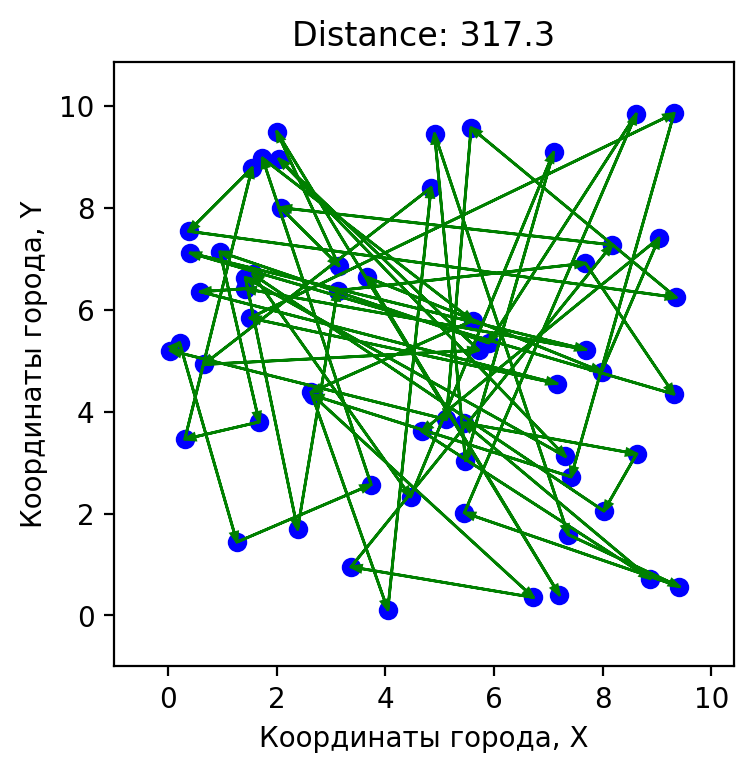

In [19]:
plot_TSP(random_route)

## Алгоритм имитации отжига

Алгоритм имитации отжига (англ. simulated annealing) — эвристический алгоритм глобальной оптимизации, особенно эффективный при решении дискретных и комбинаторных задач.

Алгоритм вдохновлён процессом отжига в металлургии — техники, заключающейся в нагревании и контролируемом охлаждении металла, чтобы увеличить его кристаллизованность и уменьшить дефекты. Симулированние отжига в переборных задачах может быть использовано для приближённого нахождения глобального минимума функций с большим количеством свободных переменных.

### Основные шаги алгоритма

```{python}
1.Выбор начального решения и начальной температуры:
2.Оценка начального решения
3.Основной шаг алгоритма
4.Случайное изменение текущего решения
5.Оценка измененного решения
6.Критерий допуска
7.Уменьшение температуры и, если температура больше некоторого порога, то переход к основному шаг
```    

### Области применения
```{python}
Создание пути
Реконструкция изображения
Назначение задач и планирование
Размещение сети
Глобальная маршрутизация
Обнаружение и распознавание визуальных объектов
Разработка специальных цифровых фильтров
```   

In [20]:
def do_transition(prob: float) -> bool:
    rand_value = random.random() # ~Uniform(0, 1)
    return rand_value <= prob


def transition_prob(func_val_diff: float, temp: float):
    return np.e ** (-func_val_diff/temp)


def calc_temp(start_temp: float, num_iter: int, cur_iter: int) -> float:
    return start_temp * (1 - cur_iter/num_iter)


def generate_candidate_route(route: List[City]) -> List[City]:
    route_len = len(route)
    
    first_city_idx = random.randint(0, route_len-1)
    second_city_idx = random.randint(0, route_len-1)
    if first_city_idx > second_city_idx:
        first_city_idx, second_city_idx = second_city_idx, first_city_idx

    # 1 2 3 4 -> 1 4 3 2
    new_route = copy.copy(route)
    new_route[first_city_idx : second_city_idx] = reversed(new_route[first_city_idx : second_city_idx]) 
    return new_route


In [21]:
def optimize_with_annealing(route: List[City], num_iter=1000, start_temp=30, plot_history=True) -> List[City]:
    cur_route_fitness = DistFitness(route)
    
    history = []
    
    for cur_iter in tqdm(range(num_iter)):
        # на каждой итерации генерируем кандидата для расмотрения
        candidate_route = generate_candidate_route(route)
        candidate_fitness = DistFitness(candidate_route)
        # и считаем значение функции для кандидата и текущего объекта
        cur_route_dist = cur_route_fitness.calc_fitness()
        candidate_dist = candidate_fitness.calc_fitness()
        
        history.append(cur_route_dist)
        # если текущая дорога длинее 
        if cur_route_dist > candidate_dist:
            # делаем переход (с вероятностью равной 1) в это состояние
            route = candidate_route
            cur_route_fitness = candidate_fitness
        else:
            # иначе рассчитываем температуру
            cur_iter_temp = calc_temp(start_temp, num_iter, cur_iter)
            func_val_diff = candidate_dist - cur_route_dist
            # и вероятность перехода в новое состояние (которое хуже с точки зрения дистанции)
            cur_iter_transition_prob = transition_prob(func_val_diff, cur_iter_temp)
            # бросаем монетку
            make_transition = do_transition(cur_iter_transition_prob)
            
            if make_transition:
                # осуществляем переход, если случайная величина так решила
                route = candidate_route
                cur_route_fitness = candidate_fitness
                
    if plot_history:
        fig = plt.figure(figsize=(5,5), dpi=100)
        ax = fig.add_subplot(111)
        ax.plot(history)
        plt.title('Значение дистанции в зависимости от номера итерации')
        plt.xlabel('Номер итерации')
        plt.ylabel('Проходимое торговцем расстояние');
    return route


  0%|          | 0/100000 [00:00<?, ?it/s]

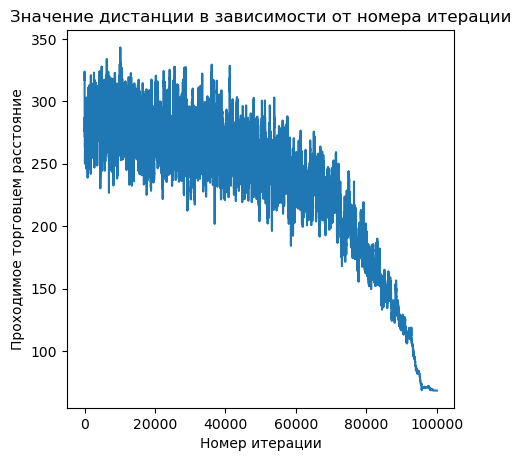

In [25]:
random.seed(2021)
best_route_annealing = optimize_with_annealing(random_route, num_iter=100000, start_temp=10, plot_history=True)

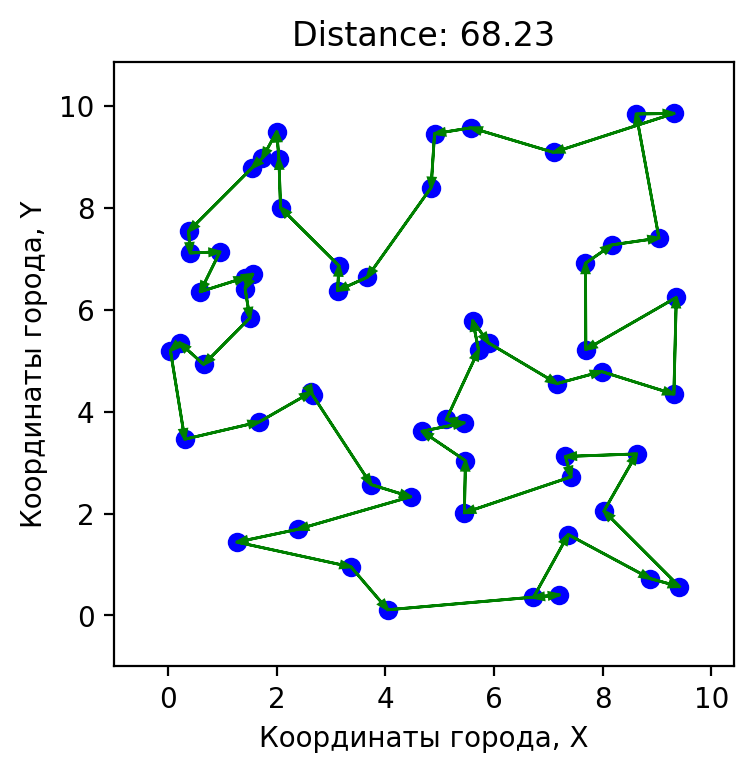

In [26]:
plot_TSP(best_route_annealing)